<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/12_DepthModel_LRRangeTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Sat May 23 21:57:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! pip install git+https://github.com/satyajitghana/ProjektDepth --upgrade

  Cloning https://github.com/satyajitghana/ProjektDepth to /tmp/pip-req-build-1brdana6
  Running command git clone -q https://github.com/satyajitghana/ProjektDepth /tmp/pip-req-build-1brdana6
     |████████████████████████████████| 163kB 3.5MB/s 
     |████████████████████████████████| 634kB 8.8MB/s 
  Created wheel for vathos: filename=vathos-0.0.1-cp36-none-any.whl size=21103 sha256=7f6f553f5100c0c228389ef8488eb055f0ae482dc267f1a571248ee847d5a333
  Stored in directory: /tmp/pip-ephem-wheel-cache-cftte2im/wheels/d2/d5/4d/f81c8b5b555fb477f148552bf512e5e98404e63bd793ab920f
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=e850b1518b9da6c2db9ec4bba9c629b802f10c972c3420265f6a276a97cc5601
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built vathos imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
import vathos
import vathos.runner as vrunner
import vathos.utils as vutils
import vathos.model as vmodel
import vathos.data_loader as vdata_loader
import vathos.model.loss as vloss

import os
from pathlib import Path
from zipfile import ZipFile
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc
from tqdm.auto import tqdm, trange
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchsummary import summary
import torch.nn as nn
import torchvision.transforms as T
import glob
import torch
import sys
from typing import List, Tuple
import yaml
import numpy as np
import time
import torch.nn.functional as F
import torch.optim as optim

In [0]:
%%time
dataset = vdata_loader.DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

Extracting the zip files


Extracting bg_small.zip ...
Extracting fg_bg_small.zip ...
Extracting fg_bg_mask_small.zip ...
Extracting depth_fg_bg_small.zip ...

found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images
CPU times: user 1min 30s, sys: 43.7 s, total: 2min 13s
Wall time: 3min 9s


In [0]:
%%time
# 70 - 30 split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

CPU times: user 23.3 ms, sys: 6.15 ms, total: 29.4 ms
Wall time: 60.5 ms


In [0]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [0]:
model = vmodel.ResUNet()

In [0]:
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)

In [0]:
lr_finder = LRFinder(model, optimizer, device="cuda")

In [0]:
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


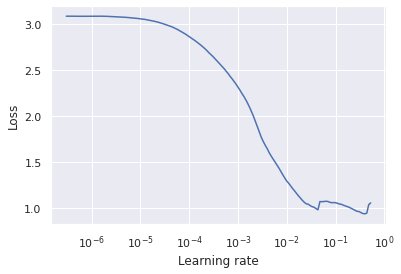

In [0]:
lr_finder.plot() # to inspect the loss-learning rate graph
plt.show()

In [0]:
sorted_lr = [(lr, loss) for lr, loss in sorted(zip(lr_finder.history['loss'], lr_finder.history['lr'])) ]

In [0]:
sorted_lr[:40]

[(0.9385480574505856, 0.3981071705534969),
 (0.9416598229802837, 0.36307805477010097),
 (0.9451743371437453, 0.43651583224016566),
 (0.9519436138969963, 0.3311311214825908),
 (0.9636485407333945, 0.3019951720402019),
 (0.9658887396341221, 0.2754228703338169),
 (0.976011964321728, 0.25118864315095824),
 (0.9824401203530206, 0.04365158322401656),
 (0.9871677125133919, 0.22908676527677746),
 (0.99486563119315, 0.03981071705534969),
 (0.9982885806851061, 0.2089296130854041),
 (1.0095215815297838, 0.19054607179632482),
 (1.010131191925238, 0.036307805477010104),
 (1.0165205469424583, 0.03311311214825908),
 (1.0169920940139918, 0.17378008287493762),
 (1.0249562910710541, 0.1584893192461114),
 (1.0282587995335781, 0.03019951720402019),
 (1.0326495161720293, 0.1445439770745928),
 (1.0372819251609782, 0.47863009232263803),
 (1.041811302154543, 0.13182567385564073),
 (1.043007790018103, 0.027542287033381692),
 (1.0452499168476326, 0.12022644346174131),
 (1.0472042738021272, 0.02511886431509582),

# Conclusion

### MAX LR = 0.2

In [0]:
def apply_on_batch(batch, apply_func):
    batch['bg'] = apply_func(batch['bg'])
    batch['fg_bg'] = apply_func(batch['fg_bg'])
    batch['fg_bg_mask'] = apply_func(batch['fg_bg_mask'])
    batch['depth_fg_bg'] = apply_func(batch['depth_fg_bg'])

    return batch

In [0]:
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt

try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    import logging

    logging.basicConfig()
    logger = logging.getLogger(__name__)
    logger.warning(
        "To enable mixed precision training, please install `apex`. "
        "Or you can re-install this package by the following command:\n"
        '  pip install torch-lr-finder -v --global-option="amp"'
    )
    IS_AMP_AVAILABLE = False
    del logging


class LRFinder(object):

    def __init__(
        self,
        model,
        optimizer,
        device=None,
        memory_cache=True,
        cache_dir=None,
    ):
        # Check if the optimizer is already attached to a scheduler
        self.optimizer = optimizer

        self.model = model
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        self.seg_loss = vloss.BCEDiceLoss()
        self.depth_loss = vloss.RMSELoss()

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def range_test(
        self,
        train_loader,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):

        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iter_wrapper = DataLoaderIterWrapper(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                iter_wrapper,
                accumulation_steps,
                non_blocking_transfer=non_blocking_transfer,
            )

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _set_learning_rate(self, new_lrs):
        if not isinstance(new_lrs, list):
            new_lrs = [new_lrs] * len(self.optimizer.param_groups)
        if len(new_lrs) != len(self.optimizer.param_groups):
            raise ValueError(
                "Length of `new_lrs` is not equal to the number of parameter groups "
                + "in the given optimizer"
            )

        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr

    def _train_batch(
        self, iter_wrapper, accumulation_steps, non_blocking_transfer=True
    ):
        self.model.train()
        total_loss = None  # for late initialization

        self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            data = next(iter_wrapper)
            data = apply_on_batch(data, lambda x: x.to(self.device, non_blocking=True))

            # Forward pass
            x = torch.cat([data['bg'], data['fg_bg']], dim=1)
            d_out, s_out = model(x)

            l1 = self.seg_loss(s_out, data['fg_bg_mask'])
            l2 = self.depth_loss(d_out, data['depth_fg_bg'])

            loss = l1 + 2*l2

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()

    def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")
        if show_lr is not None and not isinstance(show_lr, float):
            raise ValueError("show_lr must be float")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Create the figure and axes object if axes was not already given
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        # Plot loss as a function of the learning rate
        ax.plot(lrs, losses)
        if log_lr:
            ax.set_xscale("log")
        ax.set_xlabel("Learning rate")
        ax.set_ylabel("Loss")

        if show_lr is not None:
            ax.axvline(x=show_lr, color="red")

        # Show only if the figure was created internally
        if fig is not None:
            plt.show()

        return ax


class LinearLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(fn)
                )
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


class DataLoaderIterWrapper(object):
    """A wrapper for iterating `torch.utils.data.DataLoader` with the ability to reset
    itself while `StopIteration` is raised."""

    def __init__(self, data_loader, auto_reset=True):
        self.data_loader = data_loader
        self.auto_reset = auto_reset
        self._iterator = iter(data_loader)

    def __next__(self):
        # Get a new set of inputs and labels
        try:
            data = next(self._iterator)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            data = next(self._iterator)

        return data

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
%%writefile small_data.yaml
name: vathos_small_train
log_dir: "/content/gdrive/My Drive/Run/logs"
chkpt_dir: "/content/gdrive/My Drive/Run/checkpoint"

model_init: "models/model.pt"

device: GPU

model: ResUNet

augmentation: DepthLightAug

dataset:
    name: DenseDepth
    root: vathos_data
    zip_dir: "/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/"
    div_factor: 1
    loader_args:
        batch_size: 128
        num_workers: 4
        shuffle: True
        pin_memory: True

seg_loss: BCEDiceLoss

depth_loss: RMSELoss

lr_scheduler:
    type: OneCycleLR
    args:
        max_lr: 0.6

optimizer:
    type: AdamW
    args:
        lr: 0.01

training:
    epochs: 3

Overwriting small_data.yaml


In [0]:
import vathos
import vathos.runner as vrunner
import vathos.utils as vutils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
config = vutils.load_config('small_data.yaml')

In [0]:
runner = vrunner.Runner(config)

                                                                     
                            ___      ,---,                           
       ,---.              ,--.'|_  ,--.' |                           
      /__./|              |  | :,' |  |  :       ,---.               
 ,---.;  ; |              :  : ' : :  :  :      '   ,'\   .--.--.    
/___/ \  | |   ,--.--.  .;__,'  /  :  |  |,--. /   /   | /  /    '   
\   ;  \ ' |  /       \ |  |   |   |  :  '   |.   ; ,. :|  :  /`./   
 \   \  \: | .--.  .-. |:__,'| :   |  |   /' :'   | |: :|  :  ;_     
  ;   \  ' .  \__\/: . .  '  : |__ '  :  | | |'   | .; : \  \    `.  
   \   \   '  ," .--.; |  |  | '.'||  |  ' | :|   :    |  `----.   \ 
    \   `  ; /  /  ,.  |  ;  :    ;|  :  :_:,' \   \  /  /  /`--'  / 
     :   \ |;  :   .'   \ |  ,   / |  | ,'      `----'  '--'.     /  
      '---" |  ,     .-./  ---`-'  `--''                  `--'---'   
             `--`---'                                                
                    

In [0]:
runner.setup_train()

[ 2020-05-23 21:10:40,171 - vathos.vathos.runner.runner ] INFO: Config
[ 2020-05-23 21:10:40,173 - vathos.vathos.runner.runner ] INFO: {'augmentation': 'DepthLightAug',
[ 2020-05-23 21:10:40,174 - vathos.vathos.runner.runner ] INFO:  'chkpt_dir': '/content/gdrive/My Drive/Run/checkpoint',
[ 2020-05-23 21:10:40,176 - vathos.vathos.runner.runner ] INFO:  'dataset': {'div_factor': 1,
[ 2020-05-23 21:10:40,176 - vathos.vathos.runner.runner ] INFO:              'loader_args': {'batch_size': 128,
[ 2020-05-23 21:10:40,178 - vathos.vathos.runner.runner ] INFO:                              'num_workers': 4,
[ 2020-05-23 21:10:40,179 - vathos.vathos.runner.runner ] INFO:                              'pin_memory': True,
[ 2020-05-23 21:10:40,181 - vathos.vathos.runner.runner ] INFO:                              'shuffle': True},
[ 2020-05-23 21:10:40,183 - vathos.vathos.runner.runner ] INFO:              'name': 'DenseDepth',
[ 2020-05-23 21:10:40,184 - vathos.vathos.runner.runner ] INFO:       

In [0]:
runner.trainer.start_train()

[ 2020-05-23 21:11:04,589 - vathos.vathos.trainer.gpu_trainer ] INFO: => Training Started
[ 2020-05-23 21:11:04,591 - vathos.vathos.trainer.gpu_trainer ] INFO: Training the model for 3 epochs
[ 2020-05-23 21:11:04,593 - vathos.vathos.trainer.gpu_trainer ] INFO: => LR was set to 0.02400000000000002
[ 2020-05-23 21:11:04,594 - vathos.vathos.trainer.gpu_trainer ] INFO: Training Epoch 0



[ 2020-05-23 21:12:21,281 - vathos.vathos.trainer.gpu_trainer ] INFO: Testing Epoch 0



[ 2020-05-23 21:12:37,351 - vathos.vathos.trainer.gpu_trainer ] INFO: mIOU: 0.0 mRMSE: 0.6348937749862671
[ 2020-05-23 21:12:40,587 - vathos.vathos.trainer.gpu_trainer ] INFO: => Accuracy improved, saving checkpoint ...
[ 2020-05-23 21:12:42,075 - vathos.vathos.trainer.gpu_trainer ] INFO: => LR was set to 0.596143338756626
[ 2020-05-23 21:12:42,075 - vathos.vathos.trainer.gpu_trainer ] INFO: Training Epoch 1



[ 2020-05-23 21:13:57,764 - vathos.vathos.trainer.gpu_trainer ] INFO: Testing Epoch 1



[ 2020-05-23 21:14:14,042 - vathos.vathos.trainer.gpu_trainer ] INFO: mIOU: 0.14126457273960114 mRMSE: 0.3293454349040985
[ 2020-05-23 21:14:17,468 - vathos.vathos.trainer.gpu_trainer ] INFO: => Accuracy improved, saving checkpoint ...
[ 2020-05-23 21:14:18,894 - vathos.vathos.trainer.gpu_trainer ] INFO: => LR was set to 0.2743169315309916
[ 2020-05-23 21:14:18,895 - vathos.vathos.trainer.gpu_trainer ] INFO: Training Epoch 2



[ 2020-05-23 21:15:34,588 - vathos.vathos.trainer.gpu_trainer ] INFO: Testing Epoch 2



[ 2020-05-23 21:15:50,688 - vathos.vathos.trainer.gpu_trainer ] INFO: mIOU: 0.4117630124092102 mRMSE: 0.3292577266693115
[ 2020-05-23 21:15:54,203 - vathos.vathos.trainer.gpu_trainer ] INFO: => Accuracy improved, saving checkpoint ...


In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%reload_ext tensorboard

In [0]:
!kill 3047

/bin/bash: line 0: kill: (3047) - No such process


In [0]:
%tensorboard --logdir /content/gdrive/My\ Drive/Run/logs

In [0]:
! rm -r checkpoint

In [0]:
! rm -r logs

In [0]:
! nvidia-smi

Sat May 23 19:07:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  